In [ ]:
from google.colab import drive

In [ ]:
! pip install patool

     |████████████████████████████████| 77 kB 4.4 MB/s 


Loading and importing

In [ ]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!ls '/content/gdrive/My Drive/tensorflow_course'

101_food_classes_10_percent_saved_big_dog_model  dataset.rar


In [ ]:
!cp '/content/gdrive/My Drive/tensorflow_course/dataset.rar' dataset.rar

In [ ]:
import patoolib

In [ ]:
patoolib.extract_archive("dataset.rar")

patool: Extracting dataset.rar ...
patool: running /usr/bin/unrar x -- /content/dataset.rar
patool:     with cwd='./Unpack__6tbycl6'
patool: ... dataset.rar extracted to `dataset'.


'dataset'

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Flatten

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import random
import matplotlib.pyplot as plt
import os

Visualization of data

In [ ]:
def get_random_file(class_name, data_type):

  target_dir = "dataset/"+data_type+"/"+class_name
  random_file = random.sample(os.listdir(target_dir), 1)

  return target_dir+"/"+random_file[0]

In [ ]:
class_names = ["with_mask", "without_mask"]

(600, 600, 3)


(-0.5, 599.5, 599.5, -0.5)

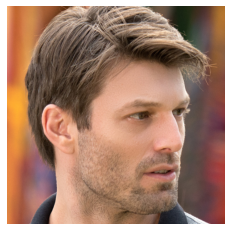

In [ ]:
img = plt.imread(get_random_file("without_mask","train"))
print(img.shape)
plt.figure()
plt.imshow(img)
plt.axis(False)

Preprocessing

In [ ]:
train_path = "dataset/train/"
test_path = "dataset/test/"

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(train_path,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               color_mode="rgba")

test_data = test_datagen.flow_from_directory(test_path,
                                             batch_size=32,
                                             target_size=(224, 224),
                                             class_mode="binary",
                                             color_mode="rgba")

Found 352 images belonging to 2 classes.
Found 88 images belonging to 2 classes.


Model

In [ ]:
mask_model = tf.keras.Sequential([
      Conv2D(10, kernel_size=3, input_shape=(224, 224, 4), activation="relu"),
      Conv2D(10, kernel_size=3, activation="relu"),
      MaxPool2D(2),
      Conv2D(10, kernel_size=3, activation="relu"),
      Conv2D(10, kernel_size=3, activation="relu"),
      Flatten(),
      Dense(1, activation="sigmoid")
])

mask_model.compile(loss="binary_crossentropy",
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=["accuracy"])

In [ ]:
mask_model_history = mask_model.fit(train_data,
                                    epochs=10,
                                    steps_per_epoch=len(train_data),
                                    validation_data=test_data,
                                    validation_steps=len(test_data))

Epoch 1/10
11/11 [==============================] - 40s 935ms/step - loss: 0.6862 - accuracy: 0.5653 - val_loss: 0.5727 - val_accuracy: 0.7500
Epoch 2/10
11/11 [==============================] - 10s 873ms/step - loss: 0.5174 - accuracy: 0.7869 - val_loss: 0.3693 - val_accuracy: 0.8068
Epoch 3/10
11/11 [==============================] - 10s 861ms/step - loss: 0.4511 - accuracy: 0.8011 - val_loss: 0.3650 - val_accuracy: 0.8750
Epoch 4/10
11/11 [==============================] - 9s 863ms/step - loss: 0.3485 - accuracy: 0.8551 - val_loss: 0.2926 - val_accuracy: 0.9318
Epoch 5/10
11/11 [==============================] - 9s 844ms/step - loss: 0.2823 - accuracy: 0.8864 - val_loss: 0.2761 - val_accuracy: 0.8977
Epoch 6/10
11/11 [==============================] - 10s 868ms/step - loss: 0.1820 - accuracy: 0.9347 - val_loss: 0.2853 - val_accuracy: 0.8864
Epoch 7/10
11/11 [==============================] - 10s 887ms/step - loss: 0.1078 - accuracy: 0.9602 - val_loss: 0.3174 - val_accuracy: 0.8864
E

Validation

In [ ]:
mask_model.evaluate(test_data)

3/3 [==============================] - 1s 379ms/step - loss: 0.3886 - accuracy: 0.9091


[0.38858166337013245, 0.9090909361839294]

In [ ]:
def plot_history_data(history):

  loss = history["loss"]
  val_loss = history["val_loss"]

  epoch = range(len(history['loss']))

  accuracy = history["accuracy"]
  val_accuracy = history["val_accuracy"]

  # Plotting the loss data
  plt.figure()
  plt.title("Losses")
  plt.plot(epoch, loss, label="training_loss")
  plt.plot(epoch, val_loss, label="validation_loss")
  plt.legend()

  plt.figure()
  plt.title("Accuracy")
  plt.plot(epoch, accuracy, label="training_accuracy")
  plt.plot(epoch, val_accuracy, label="validation_accuracy")
  plt.legend()

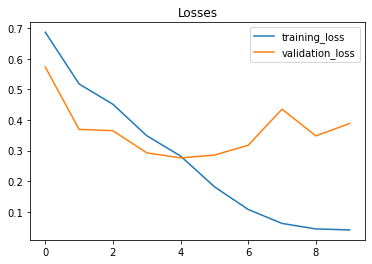

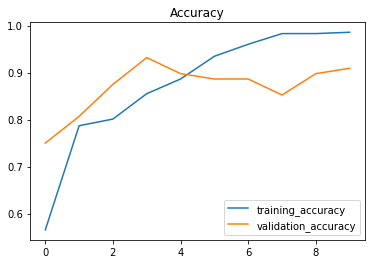

In [ ]:
plot_history_data(mask_model_history.history)

Making app out of it

In [ ]:
! pip install tensorflow_io

     |████████████████████████████████| 22.7 MB 28.0 MB/s 
     |████████████████████████████████| 2.3 MB 16.2 MB/s 


In [ ]:
from PIL import Image
import numpy as np
import tensorflow_io as tfio
import cv2
import time

In [ ]:
def validate_random_data():

  random_class = random.choice(class_names)
  random_file = get_random_file(random_class, "test")

  img = plt.imread(random_file)

  if random_class is "without_mask":

    b_channel, g_channel, r_channel = cv2.split(img)

    alpha_channel = np.ones(b_channel.shape, dtype=b_channel.dtype) * 50 #creating a dummy alpha channel image.

    img = cv2.merge((b_channel, g_channel, r_channel, alpha_channel))

  plt.figure()
  plt.imshow(img)
  plt.axis(False)

  img = img/255.
  img = tf.image.resize(img, size=[224, 224])

  prediction = mask_model.predict(tf.expand_dims(img, axis=0))

  if prediction > 0.249999:
    predicted_class = "Wearing mask"
  else:
    predicted_class = "Not Wearing mask"

  plt.title(predicted_class)

  return predicted_class

[[0.26917002]]


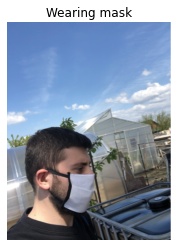

In [ ]:
img = validate_random_data()

In [ ]:
mask_model.save("gdrive/MyDrive/AIProjects/mask_detection/models/mask_model_v1") 

INFO:tensorflow:Assets written to: gdrive/MyDrive/AIProjects/mask_detection/models/mask_model_v1/assets
